## 1. Load data

In [1]:
import os
import gc
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
import lightgbm as lgb
import joblib

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_DIR = Path('data')
RAW_DIR = DATA_DIR / 'raw'
RAW_DIR.mkdir(parents=True, exist_ok=True)


# Attempt to download the 2024 ATP matches CSV from Jeff Sackmann's GitHub
url = 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2024.csv'
print('No local CSVs found — attempting to download sample dataset from GitHub:', url)
try:
    matches = pd.read_csv(url, low_memory=False)
    matches.to_csv(RAW_DIR / 'atp_matches_2024.csv', index=False)
    print('Downloaded sample CSV to', RAW_DIR / 'atp_matches_2024.csv')
except Exception as e:
    raise RuntimeError('Failed to find or download data. Place Sackmann CSVs in data/raw/') from e

print('Initial rows:', len(matches))
matches.head()

No local CSVs found — attempting to download sample dataset from GitHub: https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2024.csv
Downloaded sample CSV to data\raw\atp_matches_2024.csv
Initial rows: 3076


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2024-0339,Brisbane,Hard,32,A,20240101,300,105777,2.0,NaN,...,58.0,44.0,16.0,11.0,8.0,9.0,14.0,2570.0,8.0,3660.0
1,2024-0339,Brisbane,Hard,32,A,20240101,299,208029,1.0,NaN,...,35.0,31.0,10.0,11.0,5.0,7.0,8.0,3660.0,39.0,1122.0
2,2024-0339,Brisbane,Hard,32,A,20240101,298,105777,2.0,NaN,...,39.0,24.0,14.0,10.0,5.0,7.0,14.0,2570.0,55.0,902.0
3,2024-0339,Brisbane,Hard,32,A,20240101,297,208029,1.0,NaN,...,51.0,31.0,16.0,10.0,3.0,5.0,8.0,3660.0,116.0,573.0
4,2024-0339,Brisbane,Hard,32,A,20240101,296,126128,NaN,NaN,...,37.0,27.0,16.0,10.0,5.0,8.0,39.0,1122.0,44.0,1021.0


## 2. Cleaning & standardization

Keeping only essential columns for the demo and ensure date and surface are normalized.

In [3]:
# Normalize columns that differ by year — common Sackmann schema includes: "tourney_date", "winner_name", "loser_name", "surface", "winner_rank", "loser_rank"
# coerce common column names to the expected set.

def canonicalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    col_map = {}
    # typical names -> target
    mapping_candidates = {
        'tourney_date': ['tourney_date', 'tourney_date'],
        'surface': ['surface'],
        'winner_name': ['winner_name', 'winner'],
        'loser_name': ['loser_name', 'loser'],
        'winner_rank': ['winner_rank', 'wrank', 'winner_rank'],
        'loser_rank': ['loser_rank', 'lrank', 'loser_rank'],
        'score': ['score'],
    }
    for target, candidates in mapping_candidates.items():
        for c in candidates:
            if c in df.columns:
                col_map[c] = target
                break
    df = df.rename(columns=col_map)
    return df

matches = canonicalize_columns(matches)
# ensure tourney_date exists
if 'tourney_date' not in matches.columns:
    # Some CSVs have 'tourney_date' as integer YYYYMMDD. Try to find similar column
    for c in matches.columns:
        if 'date' in c:
            matches = matches.rename(columns={c: 'tourney_date'})
            break

# Parse date
matches['tourney_date'] = pd.to_datetime(matches['tourney_date'], format='%Y%m%d', errors='coerce')
# Drop rows without a parsable date or without winner/loser
matches = matches.dropna(subset=['tourney_date','winner_name','loser_name'])
# Simplify surface values
matches['surface'] = matches['surface'].fillna('Unknown').str.lower().map(
    lambda s: 'hard' if 'hard' in s else ('clay' if 'clay' in s else ('grass' if 'grass' in s else 'other'))
)

# Keep and rename ranks where available
for col in ['winner_rank','loser_rank']:
    if col in matches.columns:
        matches[col] = pd.to_numeric(matches[col], errors='coerce')

matches = matches.sort_values('tourney_date').reset_index(drop=True)
print('After cleaning rows:', len(matches))
matches.head()

After cleaning rows: 3076


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2024-0339,Brisbane,hard,32,A,2024-01-01,300,105777,2.0,NaN,...,58.0,44.0,16.0,11.0,8.0,9.0,14.0,2570.0,8.0,3660.0
1,2024-0336,Hong Kong,hard,32,A,2024-01-01,295,124116,NaN,NaN,...,50.0,35.0,8.0,10.0,4.0,6.0,43.0,1048.0,57.0,886.0
2,2024-0336,Hong Kong,hard,32,A,2024-01-01,296,209992,NaN,WC,...,34.0,28.0,11.0,10.0,6.0,8.0,183.0,335.0,16.0,2310.0
3,2024-0336,Hong Kong,hard,32,A,2024-01-01,297,126094,1.0,NaN,...,53.0,38.0,15.0,13.0,7.0,10.0,5.0,4805.0,36.0,1158.0
4,2024-0336,Hong Kong,hard,32,A,2024-01-01,298,200325,NaN,NaN,...,56.0,40.0,22.0,15.0,9.0,12.0,69.0,771.0,43.0,1048.0


## 3. Elo implementation (online)

We will compute an Elo rating per player using chronological updates. We'll keep a global Elo and a surface-specific Elo (hard/clay/grass)

In [5]:
from collections import defaultdict

BASE_ELO = 1500
K_BASE = 32

# Helper functions

def expected_score(r_a, r_b):
    return 1.0 / (1.0 + 10 ** ((r_b - r_a) / 400.0))

class EloTracker:
    def __init__(self, base=BASE_ELO, K=K_BASE, surfaces=('hard','clay','grass','other')):
        self.base = base
        self.K = K
        self.ratings = defaultdict(lambda: base)
        # surface-specific ratings
        self.surface_ratings = {s: defaultdict(lambda: base) for s in surfaces}

    def get(self, player, surface=None):
        if surface is None:
            return self.ratings[player]
        return self.surface_ratings.get(surface, {}).get(player, self.base)

    def update(self, winner, loser, surface=None):
        # global
        Rw = self.ratings[winner]
        Rl = self.ratings[loser]
        Ew = expected_score(Rw, Rl)
        El = 1 - Ew
        self.ratings[winner] = Rw + self.K * (1 - Ew)
        self.ratings[loser]  = Rl + self.K * (0 - El)
        # surface
        if surface in self.surface_ratings:
            Rs_w = self.surface_ratings[surface][winner]
            Rs_l = self.surface_ratings[surface][loser]
            Es_w = expected_score(Rs_w, Rs_l)
            Es_l = 1 - Es_w
            self.surface_ratings[surface][winner] = Rs_w + self.K * (1 - Es_w)
            self.surface_ratings[surface][loser]  = Rs_l + self.K * (0 - Es_l)

# Walk through matches and compute elos as of *before* each match
elo_tracker = EloTracker()

# We'll store per-match elo for winner and loser (before the match) so they can be used as features.
elo_before_w = []
elo_before_l = []
elo_surf_before_w = []
elo_surf_before_l = []

for idx, row in matches.iterrows():
    w = row['winner_name']
    l = row['loser_name']
    surf = row['surface'] if 'surface' in row and pd.notna(row['surface']) else 'other'
    # record before-match elos
    elo_before_w.append(elo_tracker.get(w))
    elo_before_l.append(elo_tracker.get(l))
    elo_surf_before_w.append(elo_tracker.get(w, surface=surf))
    elo_surf_before_l.append(elo_tracker.get(l, surface=surf))
    # update after match
    elo_tracker.update(w, l, surface=surf)

matches['elo_before_w'] = elo_before_w
matches['elo_before_l'] = elo_before_l
matches['elo_surf_before_w'] = elo_surf_before_w
matches['elo_surf_before_l'] = elo_surf_before_l

print('Elo computed for matches')

Elo computed for matches


In [7]:
matches['elo_surf_before_w']

0       1500.000000
1       1500.000000
2       1500.000000
3       1500.000000
4       1500.000000
           ...     
3071    1522.799426
3072    1568.778107
3073    1581.126242
3074    1471.002338
3075    1528.870762
Name: elo_surf_before_w, Length: 3076, dtype: float64

## 4. Rolling features

form (last K matches win rate), surface winrate, days_since_last_match

We'll build a per-player running history and then for each match extract player-level stats *up to but not including that match*.

In [9]:
# Build a structure of per-player matches
players = set(matches['winner_name']).union(set(matches['loser_name']))

# create long-form per-player match results for rolling computations
# For each match, create two entries: player, opponent, did_win, date, surface
rows = []
for _, r in matches.iterrows():
    d = r['tourney_date']
    surf = r['surface']
    rows.append({'player': r['winner_name'], 'opponent': r['loser_name'], 'did_win': 1, 'date': d, 'surface': surf})
    rows.append({'player': r['loser_name'], 'opponent': r['winner_name'], 'did_win': 0, 'date': d, 'surface': surf})

player_history = pd.DataFrame(rows).sort_values('date').reset_index(drop=True)

# compute last_k_winrate, last_k_surface_winrate, days_since_last

from collections import deque, defaultdict

K = 8  # last K matches for form

# initialize per-player rolling deques
recent_results = defaultdict(lambda: deque(maxlen=K))
recent_dates = defaultdict(lambda: deque(maxlen=K))

# iterate through player_history and compute features for each player-row (which correspond to matches in chronological order)
player_history['last_k_winrate'] = np.nan
player_history['last_k_surface_winrate'] = np.nan
player_history['days_since_last'] = np.nan

# To compute surface-specific winrate we need per-player surface history
surface_history = defaultdict(lambda: defaultdict(lambda: deque(maxlen=K)))

for idx, row in player_history.iterrows():
    p = row['player']
    d = row['date']
    s = row['surface']
    # last_k_winrate
    last_results = list(recent_results[p])
    if len(last_results) == 0:
        player_history.at[idx, 'last_k_winrate'] = 0.5
    else:
        player_history.at[idx, 'last_k_winrate'] = np.mean(last_results)
    # surface winrate
    surf_res = list(surface_history[p][s])
    if len(surf_res) == 0:
        player_history.at[idx, 'last_k_surface_winrate'] = 0.5
    else:
        player_history.at[idx, 'last_k_surface_winrate'] = np.mean(surf_res)
    # days since last match
    if len(recent_dates[p]) == 0:
        player_history.at[idx, 'days_since_last'] = np.nan
    else:
        player_history.at[idx, 'days_since_last'] = (d - recent_dates[p][-1]).days
    # add current match result to histories for future matches
    recent_results[p].append(row['did_win'])
    recent_dates[p].append(d)
    surface_history[p][s].append(row['did_win'])

# Merge these player-level rolling features back to the matches: for each match we need the pre-match features for winner and loser
# player_history currently has an entry for each player-match. We need to take the features *as of* that match for winner & loser rows.

# Build helper dicts keyed by (player, date) -> features
ph_feats = {}
for idx, r in player_history.iterrows():
    key = (r['player'], r['date'])
    ph_feats[key] = {
        'last_k_winrate': r['last_k_winrate'],
        'last_k_surface_winrate': r['last_k_surface_winrate'],
        'days_since_last': r['days_since_last']
    }

# for each match row, fetch winner's pre-match features and loser's pre-match features
wk = []
lk = []
w_surf = []
l_surf = []
wdays = []
ldays = []

for _, r in matches.iterrows():
    d = r['tourney_date']
    w = r['winner_name']
    l = r['loser_name']
    wk.append(ph_feats.get((w,d), {}).get('last_k_winrate', 0.5))
    lk.append(ph_feats.get((l,d), {}).get('last_k_winrate', 0.5))
    w_surf.append(ph_feats.get((w,d), {}).get('last_k_surface_winrate', 0.5))
    l_surf.append(ph_feats.get((l,d), {}).get('last_k_surface_winrate', 0.5))
    wdays.append(ph_feats.get((w,d), {}).get('days_since_last', np.nan))
    ldays.append(ph_feats.get((l,d), {}).get('days_since_last', np.nan))

matches['form_w'] = wk
matches['form_l'] = lk
matches['surf_form_w'] = w_surf
matches['surf_form_l'] = l_surf
matches['days_since_w'] = wdays
matches['days_since_l'] = ldays

print('Rolling features added')

Rolling features added


In [11]:
matches['form_w']

0       1.000000
1       0.666667
2       0.666667
3       1.000000
4       0.750000
          ...   
3071    0.750000
3072    0.750000
3073    0.750000
3074    0.500000
3075    0.750000
Name: form_w, Length: 3076, dtype: float64

## 5. Build match-difference dataset

We'll create a single row per match where features are differences (winner - loser) and label=1. We'll also create a mirrored dataset (loser-winner, label=0) for model training stability.

In [13]:
def build_diff_row(row):
    feats = {}
    # Elo diffs
    feats['elo_diff'] = row['elo_before_w'] - row['elo_before_l']
    feats['elo_surf_diff'] = row['elo_surf_before_w'] - row['elo_surf_before_l']
    # rank diff (where available) — lower rank number means better player, so flip sign to make positive -> better
    if 'winner_rank' in row and 'loser_rank' in row and pd.notna(row['winner_rank']) and pd.notna(row['loser_rank']):
        feats['rank_diff'] = (row['loser_rank'] - row['winner_rank'])
    else:
        feats['rank_diff'] = 0.0
    # form diffs
    feats['form_diff'] = row['form_w'] - row['form_l']
    feats['surf_form_diff'] = row['surf_form_w'] - row['surf_form_l']
    # days since last (negative = winner more rested)
    feats['days_since_diff'] = (row['days_since_w'] if pd.notna(row['days_since_w']) else 0) - (row['days_since_l'] if pd.notna(row['days_since_l']) else 0)
    # surface one-hot
    feats['is_hard'] = 1 if row['surface']=='hard' else 0
    feats['is_clay'] = 1 if row['surface']=='clay' else 0
    feats['is_grass'] = 1 if row['surface']=='grass' else 0
    feats['label'] = 1
    return feats

rows = []
for _, r in matches.iterrows():
    base = build_diff_row(r)
    rows.append(base)
    # mirrored row (swap sign of differences) with label 0
    mirror = {k: (-v if k.endswith('_diff') else v) for k,v in base.items() if k!='label'}
    mirror['label'] = 0
    # keep surface flags as-is (they're match-level)
    mirror['is_hard'] = base['is_hard']
    mirror['is_clay'] = base['is_clay']
    mirror['is_grass'] = base['is_grass']
    rows.append(mirror)

df_model = pd.DataFrame(rows)
print('Model dataset rows:', len(df_model))

# Drop rows with NaNs if any and create X/y
df_model = df_model.dropna().reset_index(drop=True)
features = [c for c in df_model.columns if c != 'label']
X = df_model[features]
y = df_model['label'].astype(int)

Model dataset rows: 6152


In [15]:
y

0       1
1       0
2       1
3       0
4       1
       ..
6147    0
6148    1
6149    0
6150    1
6151    0
Name: label, Length: 6152, dtype: int32

## 6. Time-aware train/test split and baseline models

We'll use TimeSeriesSplit to keep temporal order. For simplicity we'll do a single train/validation/test split based on date index.

In [17]:
# date split: train on first 70%, val 15%, test 15% by time
n = len(matches)
train_date = matches['tourney_date'].iloc[int(0.7*n)]
val_date = matches['tourney_date'].iloc[int(0.85*n)]

# To map df_model rows back to dates we can reconstruct indices: we made two rows per match in chronological order, so groups of 2 correspond to same match order
# assign "match_idx" column
num_matches = len(matches)
match_indices = np.repeat(np.arange(num_matches), 2)
if len(match_indices) != len(df_model):
    # safeguard: align by truncation or repetition
    match_indices = match_indices[:len(df_model)]

# get match dates for df_model
match_dates = matches['tourney_date'].iloc[match_indices].reset_index(drop=True)

# create boolean masks
train_mask = match_dates <= train_date
val_mask = (match_dates > train_date) & (match_dates <= val_date)
test_mask = match_dates > val_date

X_train, y_train = X[train_mask].copy(), y[train_mask].copy()
X_val, y_val = X[val_mask].copy(), y[val_mask].copy()
X_test, y_test = X[test_mask].copy(), y[test_mask].copy()

print('Train/Val/Test sizes:', len(X_train), len(X_val), len(X_test))

# %%
# Baseline: logistic regression
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

log = LogisticRegression(max_iter=1000)
log.fit(X_train_s, y_train)

def evaluate_model(clf, Xs, ys, name='model'):
    preds = clf.predict(Xs)
    probs = clf.predict_proba(Xs)[:,1] if hasattr(clf, 'predict_proba') else clf.decision_function(Xs)
    acc = accuracy_score(ys, preds)
    auc = roc_auc_score(ys, probs)
    brier = brier_score_loss(ys, probs)
    print(f'{name} — acc: {acc:.4f}, auc: {auc:.4f}, brier: {brier:.4f}')
    return {'acc':acc, 'auc':auc, 'brier':brier}

print('Logistic performance')
_eval_train = evaluate_model(log, X_train_s, y_train, 'Logistic (train)')
_eval_val = evaluate_model(log, X_val_s, y_val, 'Logistic (val)')
_eval_test = evaluate_model(log, X_test_s, y_test, 'Logistic (test)')

Train/Val/Test sizes: 4406 840 906
Logistic performance
Logistic (train) — acc: 0.8466, auc: 0.9223, brier: 0.1137
Logistic (val) — acc: 0.8238, auc: 0.8737, brier: 0.1387
Logistic (test) — acc: 0.8499, auc: 0.9320, brier: 0.1094


## 7. LightGBM classifier (non-lambdarank)

using difference features

In [19]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'seed': RANDOM_SEED,
}

bst = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train','val'],
    num_boost_round=2000,
    #early_stopping_rounds=100,
    #verbose_eval=100,
)


def summarize_preds(name, y_true, probs):
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y_true, preds)
    auc = roc_auc_score(y_true, probs)
    brier = brier_score_loss(y_true, probs)
    print(f'LightGBM ({name}) — acc: {acc:.4f}, auc: {auc:.4f}, brier: {brier:.4f}')


preds_val = bst.predict(X_val, num_iteration=bst.best_iteration)
preds_test = bst.predict(X_test, num_iteration=bst.best_iteration)
summarize_preds('val', y_val, preds_val)
summarize_preds('test', y_test, preds_test)

LightGBM (val) — acc: 0.8048, auc: 0.8688, brier: 0.1768
LightGBM (test) — acc: 0.8455, auc: 0.9245, brier: 0.1256


## 8. LambdaRank approach (learning-to-rank)

This uses two rows per match but with player features instead of differences and trains objective='lambdarank'.

In [21]:
def _player_row(row, role, match_idx):
    prefix = 'w' if role == 'w' else 'l'
    rank_key = 'winner_rank' if role == 'w' else 'loser_rank'
    return {
        'match_id': match_idx,
        'elo_before': row[f'elo_before_{prefix}'],
        'elo_surf_before': row[f'elo_surf_before_{prefix}'],
        'form': row[f'form_{prefix}'],
        'surf_form': row[f'surf_form_{prefix}'],
        'days_since': row[f'days_since_{prefix}'],
        'rank': row.get(rank_key, np.nan),
        'is_hard': 1 if row['surface'] == 'hard' else 0,
        'is_clay': 1 if row['surface'] == 'clay' else 0,
        'is_grass': 1 if row['surface'] == 'grass' else 0,
        'label': 1 if role == 'w' else 0
    }

player_rows = []
for match_idx, row in matches.iterrows():
    player_rows.append(_player_row(row, 'w', match_idx))
    player_rows.append(_player_row(row, 'l', match_idx))

rank_df = pd.DataFrame(player_rows)
rank_df['days_since'] = rank_df['days_since'].fillna(0.0)
rank_df['rank'] = rank_df['rank'].fillna(rank_df['rank'].median())
rank_features = ['elo_before','elo_surf_before','form','surf_form','days_since','rank','is_hard','is_clay','is_grass']
X_rank = rank_df[rank_features]
y_rank = rank_df['label'].astype(int)

match_train_mask = matches['tourney_date'] <= train_date
match_val_mask = (matches['tourney_date'] > train_date) & (matches['tourney_date'] <= val_date)
match_test_mask = matches['tourney_date'] > val_date

train_rank_mask = np.repeat(match_train_mask.values, 2)
val_rank_mask = np.repeat(match_val_mask.values, 2)
test_rank_mask = np.repeat(match_test_mask.values, 2)

rank_train = lgb.Dataset(X_rank[train_rank_mask], label=y_rank[train_rank_mask], group=[2]*match_train_mask.sum())
rank_val = lgb.Dataset(X_rank[val_rank_mask], label=y_rank[val_rank_mask], group=[2]*match_val_mask.sum(), reference=rank_train)

rank_params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [2],
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 63,
    'min_data_in_leaf': 30,
    'seed': RANDOM_SEED,
}

ranker = lgb.train(
    rank_params,
    rank_train,
    valid_sets=[rank_train, rank_val],
    valid_names=['train','val'],
    num_boost_round=2000,
    #early_stopping_rounds=100,
    #verbose_eval=100,
)


def evaluate_rank_split(model, mask, split_name):
    pair_mask = np.repeat(mask.values, 2)
    scores = model.predict(X_rank[pair_mask], num_iteration=model.best_iteration)
    labels = y_rank[pair_mask].values
    match_scores = scores.reshape(-1, 2)
    winner_scores = match_scores[:, 0]
    loser_scores = match_scores[:, 1]
    probs = 1 / (1 + np.exp(loser_scores - winner_scores))
    acc = (winner_scores > loser_scores).mean()
    auc = roc_auc_score(labels, scores)
    brier = np.mean((probs - labels.reshape(-1, 2)[:, 0]) ** 2)
    print(f'LambdaRank ({split_name}) — match acc: {acc:.4f}, pairwise auc: {auc:.4f}, brier: {brier:.4f}')
    return {'acc': acc, 'auc': auc, 'brier': brier}

rank_metrics = {
    'train': evaluate_rank_split(ranker, match_train_mask, 'train'),
    'val': evaluate_rank_split(ranker, match_val_mask, 'val'),
    'test': evaluate_rank_split(ranker, match_test_mask, 'test'),
}

LambdaRank (train) — match acc: 0.9968, pairwise auc: 0.9092, brier: 0.0008
LambdaRank (val) — match acc: 0.7929, pairwise auc: 0.7363, brier: 0.1855
LambdaRank (test) — match acc: 0.8256, pairwise auc: 0.7862, brier: 0.1536


## 9. Calibration check and simple reliability diagram

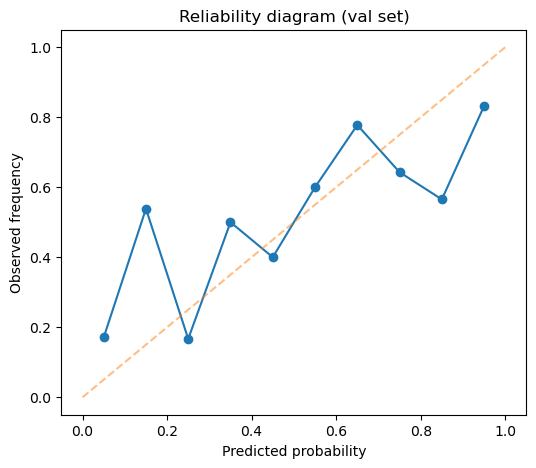

In [23]:
import matplotlib.pyplot as plt

probs = preds_val
bins = np.linspace(0, 1, 11)
bin_idx = np.digitize(probs, bins) - 1
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_true = []
for i in range(len(bin_centers)):
    mask = bin_idx == i
    bin_true.append(y_val[mask].mean() if mask.any() else np.nan)

plt.figure(figsize=(6,5))
plt.plot(bin_centers, bin_true, marker='o')
plt.plot([0,1],[0,1],'--', alpha=0.5)
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Reliability diagram (val set)')
plt.show()

## 10. Save models and scalers

In [25]:
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(exist_ok=True)
joblib.dump(scaler, MODEL_DIR / 'scaler.joblib')
joblib.dump(log, MODEL_DIR / 'logistic.joblib')
bst.save_model(str(MODEL_DIR / 'lgb_model.txt'), num_iteration=bst.best_iteration)
joblib.dump(rank_features, MODEL_DIR / 'rank_features.joblib')
ranker.save_model(str(MODEL_DIR / 'lgb_lambdarank.txt'), num_iteration=ranker.best_iteration)
print('Saved models to', MODEL_DIR)

Saved models to models
